In [774]:
import os
import sys
import time
import argparse
import plotly.express as px
import numpy as np
import pandas as pd
import zipfile
import fnmatch
import flirt.reader.empatica
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime,  timedelta

In [775]:
import zipfile,fnmatch,os
rootPath = r"./"
pattern = '*.zip'
for root, dirs, files in os.walk(rootPath):
    for filename in fnmatch.filter(files, pattern):
        print(os.path.join(root, filename))
        zipfile.ZipFile(os.path.join(root, filename)).extractall(os.path.join(root, os.path.splitext(filename)[0]))

./061821_A02078.zip
./061921_A02078.zip
./062021_A02078.zip
./062121_A02078.zip
./062221_A02078.zip
./062321_A02078.zip


In [776]:
import logging
import datetime
def join_smaller_events(feature):
    try:
        for i in range(len(feature['Starting Timestamp'])):
            # print(hr_events_df['Starting Timestamp'][i+1])
            for j in range(len(feature['Ending Timestamp'])):
                if ((feature['Starting Timestamp'][i+1] - feature['Ending Timestamp'][i]) < datetime.timedelta(minutes=10) and 
                    (feature['Starting Timestamp'][i+1] - feature['Ending Timestamp'][i]) > datetime.timedelta(minutes=0, seconds=0)):
                    feature['Starting Timestamp'][i+1] = feature['Ending Timestamp'][i]
                        # print(hr_events_df['Starting Timestamp'][i+1], '\n', hr_events_df['Ending Timestamp'][i]) 
                else:
                    pass        
    except KeyError as error:
        logging.info('range error in delta time adjustments')
        
class process:
    def __init__(self) -> None:
        pass

    def moving_avarage_smoothing(X, k, description_str):
        S = np.zeros(X.shape[0])
        for t in tqdm(range(X.shape[0]), desc=description_str):
            if t < k:
                S[t] = np.mean(X[:t+1])
            else:
                S[t] = np.sum(X[t-k:t])/k
        return S

    def deviation_above_mean(unit, mean_unit, std_unit):
        if unit == 0:
            return (mean_unit)
        else:
            return (mean_unit + (unit*std_unit))

    def Starting_timeStamp(column, time_frames, deviation_metric):
        starting_time_index = []
        for i in range(len(column)-1):
            if column[i] < deviation_metric and column[i+1] > deviation_metric:
                starting_time_index.append(time_frames[i])
        return starting_time_index

    def Ending_timeStamp(column, time_frames, deviation_metric):
        time_index = []
        for i in range(len(column)-1):
            if column[i] > deviation_metric and column[i+1] < deviation_metric:
                time_index.append(time_frames[i])
        if column[len(column) - 1] > deviation_metric:
            time_index.insert(
                len(time_index), time_frames[len(time_frames) - 1])
        else:
            pass
        return time_index
    
def round_to_secs(dt: datetime) -> datetime:
    extra_sec = round(dt.microsecond / 10 ** 6)
    return dt.replace(microsecond=0) + timedelta(seconds=extra_sec)
        


# HRV


In [777]:

import flirt.reader.empatica
ibis = flirt.reader.empatica.read_ibi_file_into_df('./061821_A02078/IBI.csv')
hrv_features = flirt.get_hrv_features(ibis['ibi'], 128, 1, ["td", "fd", "stat"], 0.2)
# hrv_features['datetime'] = hrv_features['datetime'].dt.strftime("%Y-%m-%d %H:%M:%S")
hrv_features = hrv_features.dropna(how='any',axis=0)
hrv_features.reset_index(inplace=True)
# hrv_features["Unix_timestamp"] = hrv_features["datetime"].apply(lambda x: pd.Timestamp(x).timestamp())
# hrv_features

HRV features: 100%|██████████| 50092/50092 [00:55<00:00, 907.19it/s] 


Unable to remove memmapped file


In [778]:
# hrv_features['datetime'] = hrv_features['datetime'].dt.strftime("%Y-%m-%d %H:%M:%S")
# hrv_features

In [779]:
def moving_avarage_smoothing(X,k):
	S = np.zeros(X.shape[0])
	for t in tqdm(range(X.shape[0])):
		if t < k:
			S[t] = np.mean(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

MAG_K300  = moving_avarage_smoothing(hrv_features['hrv_rmssd'], 500)
hrv_features['MAG_K300'] = MAG_K300
mean_rmssd = hrv_features['hrv_rmssd'].mean()
std_rmssd = hrv_features['hrv_rmssd'].std()
fig = px.line(hrv_features, y='MAG_K300', x = 'datetime')
fig.add_hline(y=mean_rmssd, annotation_text="Mean RMSSD",  annotation_position="bottom right")
fig.add_hline(y=std_rmssd, annotation_text="STD RMSSD",  annotation_position="bottom right")

def Starting_timeStamp(column, time_frames):
    starting_time_index = []
    for i in range(len(column)-1):
        if column[i] < mean_rmssd and column[i+1] > mean_rmssd:
            starting_time_index.append(time_frames[i])
    return starting_time_index
    
    
hrv_starting_timestamp = Starting_timeStamp(hrv_features['MAG_K300'], hrv_features['datetime'])
# index_of_starting_timestamp = Starting_timeStamp(hrv_features['MAG_K300'], hrv_features['Index'])

def Ending_timeStamp(column, time_frames):
    time_index = []
    for i in range(len(column)-1):
        if column[i] > mean_rmssd and column[i+1] < mean_rmssd:
            time_index.append(time_frames[i])
    if column[len(column) -1 ] > mean_rmssd:
        time_index.insert(len(time_index), time_frames[len(time_frames) -1])
    else:
        pass        
    return time_index

hrv_ending_timestamp = Ending_timeStamp(hrv_features['MAG_K300'], hrv_features['datetime'])
# index_of_ending_timestamp = Ending_timeStamp(hrv_features['MAG_K300'], hrv_features['Index'])

if hrv_starting_timestamp > hrv_ending_timestamp:
    hrv_ending_timestamp.pop(0)
else:
    pass

difference = [] # initialization of result list
time_delta_minutes = []
desired_time_index = []
zip_object = zip(hrv_ending_timestamp, hrv_starting_timestamp)

for list1_i, list2_i in zip_object:
    difference.append(list1_i-list2_i)# append each difference to list
for i in difference:
    time_delta_minutes.append(i.total_seconds()/60)
time_delta_minutes

for i in range(len(time_delta_minutes)):
    if time_delta_minutes[i] > 5.00:
        desired_time_index.append(i)
print(time_delta_minutes, '\n' )
# desired_time_index

hrv_starting_timestamp_df = pd.DataFrame(hrv_starting_timestamp)
hrv_ending_timestamp_df = pd.DataFrame(hrv_ending_timestamp)
frames = (hrv_starting_timestamp_df, hrv_ending_timestamp_df)
hrv_events_df = pd.concat(frames,  axis=1)
hrv_events_df.columns = ['Starting Timestamp', 'Ending Timestamp']
hrv_events_df['Starting Timestamp'] = hrv_events_df['Starting Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
hrv_events_df['Ending Timestamp'] = hrv_events_df['Ending Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
hrv_events_df = hrv_events_df.loc[desired_time_index, :]
hrv_events_df = hrv_events_df.reset_index(drop = True)



hrv_events_df


[2.3333333333333335, 81.88333333333334, 3.533333333333333, 3.3666666666666667, 26.416666666666668, 4.116666666666666, 20.466666666666665, 0.13333333333333333, 0.5166666666666667, 56.0, 58.333333333333336, 46.68333333333333, 3.283333333333333, 5.566666666666666, 3.5166666666666666, 4.7, 7.433333333333334, 1.2333333333333334, 8.4, 8.733333333333333, 84.8] 



,Starting Timestamp,Ending Timestamp
0,2021-06-18 12:20:22,2021-06-18 13:42:15
1,2021-06-18 14:06:52,2021-06-18 14:33:17
2,2021-06-18 14:56:30,2021-06-18 15:16:58
3,2021-06-18 15:31:26,2021-06-18 16:27:26
4,2021-06-18 16:28:30,2021-06-18 17:26:50
5,2021-06-18 17:30:59,2021-06-18 18:17:40
6,2021-06-18 19:15:42,2021-06-18 19:21:16
7,2021-06-18 22:24:36,2021-06-18 22:32:02
8,2021-06-18 23:30:54,2021-06-18 23:39:18
9,2021-06-18 23:41:11,2021-06-18 23:49:55


In [780]:
mean_rmssd

33.30775265145368

# Accelerometer 

In [781]:
import flirt.reader.empatica
acc_df = flirt.reader.empatica.read_acc_file_into_df('./061821_A02078/ACC.csv')
acc_df['Magnitude'] = np.sqrt(acc_df['acc_x']**2 + acc_df['acc_y']**2 + acc_df['acc_z']**2)
acc_df.reset_index(inplace=True)
# hrv_features

In [782]:
# acc_df['datetime'] = acc_df['datetime'].dt.strftime("%Y-%m-%d %H:%M:%S")
acc_df

,datetime,acc_x,acc_y,acc_z,Magnitude
0,2021-06-18 11:24:27+00:00,47,25,32,62.112801
1,2021-06-18 11:24:27.031250+00:00,42,29,31,59.715995
2,2021-06-18 11:24:27.062500+00:00,41,15,27,51.332251
3,2021-06-18 11:24:27.093750+00:00,40,17,40,59.067758
4,2021-06-18 11:24:27.125000+00:00,48,26,34,64.311741
...,...,...,...,...,...
1619155,2021-06-19 01:27:45.593750+00:00,-11,27,58,64.915329
1619156,2021-06-19 01:27:45.625000+00:00,-13,9,60,62.048368
1619157,2021-06-19 01:27:45.656250+00:00,-10,16,59,61.943523
1619158,2021-06-19 01:27:45.687500+00:00,-6,20,64,67.320131


In [783]:
def moving_avarage_smoothing(X,k):
	S = np.zeros(X.shape[0])
	for t in tqdm(range(X.shape[0])):
		if t < k:
			S[t] = np.mean(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

MAG_K300  = moving_avarage_smoothing(acc_df['Magnitude'], 500)
acc_df['MAG_K300'] = MAG_K300
mean_acc = acc_df['Magnitude'].mean()
std_acc = acc_df['Magnitude'].std()
# fig.add_hline(y=mean_acc, annotation_text="Mean RMSSD",  annotation_position="bottom right")
# fig.add_hline(y=std_acc, annotation_text="STD RMSSD",  annotation_position="bottom right")

def Starting_timeStamp(column, time_frames):
    starting_time_index = []
    for i in range(len(column)-1):
        if column[i] < mean_acc and column[i+1] > mean_acc:
            starting_time_index.append(time_frames[i])
    return starting_time_index
    
    
acc_starting_timestamp = Starting_timeStamp(acc_df['MAG_K300'], acc_df['datetime'])
# index_of_starting_timestamp = Starting_timeStamp(acc_df['MAG_K300'], acc_df['Index'])

def Ending_timeStamp(column, time_frames):
    time_index = []
    for i in range(len(column)-1):
        if column[i] > mean_acc and column[i+1] < mean_acc:
            time_index.append(time_frames[i])
    if column[len(column) -1 ] > mean_acc:
        time_index.insert(len(time_index), time_frames[len(time_frames) -1])
    else:
        pass        
    return time_index

acc_ending_timestamp = Ending_timeStamp(acc_df['MAG_K300'], acc_df['datetime'])
# index_of_ending_timestamp = Ending_timeStamp(acc_df['MAG_K300'], acc_df['Index'])

if acc_starting_timestamp > acc_ending_timestamp:
    acc_ending_timestamp.pop(0)
else:
    pass

difference = [] # initialization of result list
time_delta_minutes = []
desired_time_index = []
zip_object = zip(acc_ending_timestamp, acc_starting_timestamp)

for list1_i, list2_i in zip_object:
    difference.append(list1_i-list2_i)# append each difference to list
for i in difference:
    time_delta_minutes.append(i.total_seconds()/60)
# time_delta_minutes

for i in range(len(time_delta_minutes)):
    if time_delta_minutes[i] > 5.00:
        desired_time_index.append(i)
# print(time_delta_minutes, '\n' )
# desired_time_index

acc_starting_timestamp_df = pd.DataFrame(acc_starting_timestamp)
acc_ending_timestamp_df = pd.DataFrame(acc_ending_timestamp)
frames = (acc_starting_timestamp_df, acc_ending_timestamp_df)
acc_events_df = pd.concat(frames,  axis=1)
acc_events_df.columns = ['Starting Timestamp', 'Ending Timestamp']
acc_events_df['Starting Timestamp'] = acc_events_df['Starting Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
acc_events_df['Ending Timestamp'] = acc_events_df['Ending Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
acc_events_df = acc_events_df.loc[desired_time_index, :]
acc_events_df = acc_events_df.reset_index(drop = True)


acc_events_df

KeyboardInterrupt: 

In [ ]:
# ts = pd.Timestamp('2021-06-20 12:36:54.281250+00:00')
# ts.strftime("%Y-%m-%d %H:%M:%S")


# acc_events_df['Starting Timestamp'][3].strftime("%Y-%m-%d %H:%M:%S")
# for i in range(len(acc_events_df['Starting Timestamp'])):
#     for j in range(len(acc_events_df['Ending Timestamp'])):
#         acc_events_df['Starting Timestamp'][i] = acc_events_df['Starting Timestamp'][i].strftime("%Y-%m-%d %H:%M:%S")
#         acc_events_df['Ending Timestamp'][j] = acc_events_df['Ending Timestamp'][j].strftime("%Y-%m-%d %H:%M:%S")
# acc_events_df

# acc_events_df['Starting Timestamp'].strftime("%Y-%m-%d %H:%M:%S")



# heart  rate

In [ ]:
hr_df = flirt.reader.empatica.read_hr_file_into_df("./061821_A02078/HR.csv")
hr_df.reset_index(inplace=True)

In [ ]:
def moving_avarage_smoothing(X,k):
	S = np.zeros(X.shape[0])
	for t in tqdm(range(X.shape[0])):
		if t < k:
			S[t] = np.mean(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S

MAG_K300  = moving_avarage_smoothing(hr_df['hr'], 500)
hr_df['MAG_K300'] = MAG_K300
mean_hr = hr_df['hr'].mean()
std_hr = hr_df['hr'].std()

def Starting_timeStamp(column, time_frames):
    starting_time_index = []
    for i in range(len(column)-1):
        if column[i] < mean_hr and column[i+1] > mean_hr:
            starting_time_index.append(time_frames[i])
    return starting_time_index
    
    
# index_of_starting_timestamp = Starting_timeStamp(hrv_features['MAG_K300'], hrv_features['Index'])

def Ending_timeStamp(column, time_frames):
    time_index = []
    for i in range(len(column)-1):
        if column[i] > mean_hr and column[i+1] < mean_hr:
            time_index.append(time_frames[i])
    if column[len(column) -1 ] > mean_hr:
        time_index.insert(len(time_index), time_frames[len(time_frames) -1])
    else:
        pass        
    return time_index


hr_starting_timestamp = Starting_timeStamp(hr_df['MAG_K300'], hr_df['datetime'])
hr_ending_timestamp = Ending_timeStamp(hr_df['MAG_K300'], hr_df['datetime'])
# index_of_ending_timestamp = Ending_timeStamp(hr_df['MAG_K300'], hr_df['datetime'])

if hr_starting_timestamp > hr_ending_timestamp:
    hr_ending_timestamp.pop(0)
else:
    pass

difference = [] # initialization of result list
time_delta_minutes = []
desired_time_index = []
zip_object = zip(hr_ending_timestamp, hr_starting_timestamp)

for list1_i, list2_i in zip_object:
    difference.append(list1_i-list2_i)# append each difference to list
for i in difference:
    time_delta_minutes.append(i.total_seconds()/60)
time_delta_minutes

for i in range(len(time_delta_minutes)):
    if time_delta_minutes[i] > 5.00:
        desired_time_index.append(i)
        
hr_starting_timestamp_df = pd.DataFrame(hr_starting_timestamp)
hr_ending_timestamp_df = pd.DataFrame(hr_ending_timestamp)
frames = (hr_starting_timestamp_df, hr_ending_timestamp_df)
hr_events_df = pd.concat(frames,  axis=1)
hr_events_df.columns = ['Starting Timestamp', 'Ending Timestamp']
hr_events_df['Starting Timestamp'] = hr_events_df['Starting Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
hr_events_df['Ending Timestamp'] = hr_events_df['Ending Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
hr_events_df = hr_events_df.loc[desired_time_index, :]
hr_events_df = hr_events_df.reset_index(drop=True)

# join_smaller_events(hr_events_df)
hr_events_df

,Starting Timestamp,Ending Timestamp
0,2021-06-23 12:17:29,2021-06-23 13:32:06
1,2021-06-23 14:22:59,2021-06-23 14:40:53
2,2021-06-23 14:47:01,2021-06-23 15:04:29
3,2021-06-23 16:34:43,2021-06-23 16:58:54
4,2021-06-23 17:01:00,2021-06-23 17:06:36
5,2021-06-23 17:17:06,2021-06-23 17:47:56
6,2021-06-23 18:04:53,2021-06-23 18:16:08
7,2021-06-23 20:50:24,2021-06-23 20:57:23
8,2021-06-23 21:18:59,2021-06-23 21:24:02
9,2021-06-23 21:32:06,2021-06-23 21:42:18


In [ ]:
    # Corrected_overlapped_events = pd.DataFrame(columns=['Starting Timestamp', 'Ending Timestamp'])
    # def check_overlap(feature_1, feature_2):
    #     k = 0
    #     for i in range(len(feature_1)):
    #         for j in range(len(feature_2)):    
    #             # print(feature_1)
    #             # print(feature_2)
    #             delta_a = feature_1['Ending Timestamp'][i] - feature_1['Starting Timestamp'][i]
    #             # print("Delta A = ", delta_a)
    #             delta_b = feature_2['Ending Timestamp'][j] - feature_2['Starting Timestamp'][j]
    #             # print("Delta B = ", delta_b)
    #             c1 = min(feature_1['Starting Timestamp'][i], feature_2['Starting Timestamp'][j])
    #             # print("C1 ", c1)
    #             c2 = max(feature_2['Ending Timestamp'][j], feature_1['Ending Timestamp'][i])
    #             # print("C2 ", c2)
    #             Dc = c2-c1
    #             if ((delta_a+delta_b) > Dc):
    #                 # print(i, j)
    #                 # overlapped_events['Starting Timestamp'] = overlapped_events['Starting Timestamp'].append(pd.DataFrame(c1))
    #                 Corrected_overlapped_events.at[k, 'Starting Timestamp'] = c1
    #                 Corrected_overlapped_events.at[k, 'Ending Timestamp'] = c2
    #                 feature_1['Starting Timestamp'][i] = None
    #                 feature_1['Ending Timestamp'][i] = None
    #                 feature_2['Starting Timestamp'][j] = None
    #                 feature_2['Ending Timestamp'][j] = None
    #                 k += 1

In [ ]:
# check_overlap(hrv_events_df, acc_events_df)
# concatnated_frames_1 = pd.concat([hrv_events_df.dropna(), acc_events_df.dropna(), Corrected_overlapped_events.dropna()])
# concatnated_frames_1 = concatnated_frames_1.reset_index(drop=True)
# concatnated_frames_1 = pd.DataFrame(concatnated_frames_1)
# concatnated_frames_1

In [ ]:
# concatnated_frames_1, hr_events_df

# check_overlap(concatnated_frames_1, hr_events_df)
# concatnated_frames_2 = pd.concat([concatnated_frames_1.dropna(), acc_events_df.dropna(), Corrected_overlapped_events.dropna()])
# concatnated_frames_2 = concatnated_frames_2.reset_index(drop=True)
# concatnated_frames_2

# GSR phasic


In [ ]:
import flirt.reader.empatica
import cvxopt as cv
from neurokit2 import eda_phasic
eda_df = flirt.reader.empatica.read_eda_file_into_df('./061821_A02078/EDA.csv')
eda_df.reset_index(inplace=True)
eda = np.array(eda_df['eda'])
Phasic_Tonic_DF = eda_phasic(eda, 4, method='cvxEDA')
eda_df['tonic'] = Phasic_Tonic_DF['EDA_Tonic']
eda_df['phasic'] = Phasic_Tonic_DF['EDA_Phasic']
eda_phasic_df = eda_df.copy()

In [ ]:
# eda_df['datetime'] = eda_df['datetime'].dt.strftime("%Y-%m-%d %H:%M:%S")
eda_df

,datetime,eda,tonic,phasic
0,2021-06-23 12:01:16+00:00,0.000000,0.118805,0.000000
1,2021-06-23 12:01:16.250000+00:00,0.221444,0.115468,0.000000
2,2021-06-23 12:01:16.500000+00:00,0.293125,0.113046,0.173470
3,2021-06-23 12:01:16.750000+00:00,0.286725,0.111493,0.181949
4,2021-06-23 12:01:17+00:00,0.286725,0.110765,0.180677
...,...,...,...,...
192913,2021-06-24 01:25:04.250000+00:00,0.030720,-0.009769,0.065316
192914,2021-06-24 01:25:04.500000+00:00,0.028160,0.007630,0.057725
192915,2021-06-24 01:25:04.750000+00:00,0.029440,0.024631,0.050998
192916,2021-06-24 01:25:05+00:00,0.029440,0.041185,0.045043


In [ ]:
print('\n', '******************** Smoothing The EDA Phasic Curve ********************', '\n')
MAG_K500 = process.moving_avarage_smoothing(
    eda_phasic_df['phasic'], 2000, "Processing EDA Phasic Data")


 ******************** Smoothing The EDA Phasic Curve ******************** 



In [ ]:
eda_phasic_df['MAG_K500'] = MAG_K500
# hrv_features.to_csv('hrv_features.csv')
mean_eda_phasic = eda_phasic_df['phasic'].mean()
std_eda_phasic = eda_phasic_df['phasic'].std()

starting_timestamp = process.Starting_timeStamp(eda_phasic_df['MAG_K500'], eda_phasic_df['datetime'],
                                                process.deviation_above_mean(1, mean_eda_phasic, std_eda_phasic))

ending_timestamp = process.Ending_timeStamp(eda_phasic_df['MAG_K500'], eda_phasic_df['datetime'],
                                            process.deviation_above_mean(1, mean_eda_phasic, std_eda_phasic))

if len(starting_timestamp) < 1:
    fig, ax2 = plt.subplots(figsize=(30, 10))
    ax2.plot(eda_phasic_df['datetime'],
                eda_phasic_df['MAG_K500'], color='red')
    fig.savefig('./Plots/EDA_Phasic_figure.png')
else:
    if starting_timestamp > ending_timestamp:
        ending_timestamp.pop(0)
    difference = []  # initialization of result list
    time_delta_minutes = []
    desired_time_index = []
    zip_object = zip(ending_timestamp, starting_timestamp)
    for list1_i, list2_i in zip_object:
        # append each difference to list
        difference.append(list1_i-list2_i)
    for i in difference:
        time_delta_minutes.append(i.total_seconds()/60)
    for i in range(len(time_delta_minutes)):
        if time_delta_minutes[i] > 2.00:
            desired_time_index.append(i)
    starting_timestamp_df = pd.DataFrame(starting_timestamp)
    ending_timestamp_df = pd.DataFrame(ending_timestamp)
    frames = (starting_timestamp_df, ending_timestamp_df)
    eda_phasic_events_df = pd.concat(frames,  axis=1)
    eda_phasic_events_df.columns = ['Starting Timestamp', 'Ending Timestamp']
    eda_phasic_events_df['Starting Timestamp'] = eda_phasic_events_df['Starting Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
    eda_phasic_events_df['Ending Timestamp'] = eda_phasic_events_df['Ending Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")

    eda_phasic_events_df = eda_phasic_events_df.loc[desired_time_index, :]
    eda_phasic_events_df = eda_phasic_events_df.reset_index(drop=True)

eda_phasic_events_df

,Starting Timestamp,Ending Timestamp
0,2021-06-23 12:34:09,2021-06-23 12:42:23
1,2021-06-23 13:13:43,2021-06-23 13:22:10
2,2021-06-23 14:56:40,2021-06-23 15:02:51
3,2021-06-23 16:52:38,2021-06-23 16:57:18
4,2021-06-23 17:09:06,2021-06-23 17:14:00
5,2021-06-23 17:33:55,2021-06-23 17:36:20
6,2021-06-23 22:26:40,2021-06-23 22:28:49


# GSR Tonic

In [ ]:
eda_df = flirt.reader.empatica.read_eda_file_into_df('./061821_A02078/EDA.csv')
eda_df.reset_index(inplace=True)
eda = np.array(eda_df['eda'])
Phasic_Tonic_DF = eda_phasic(eda, 4, method='cvxEDA')
eda_df['tonic'] = Phasic_Tonic_DF['EDA_Tonic']
eda_df['phasic'] = Phasic_Tonic_DF['EDA_Phasic']
eda_tonic_df = eda_df.copy()

print('\n', '******************** Smoothing The EDA Tonic Curve ********************', '\n')
MAG_K500 = process.moving_avarage_smoothing(
    eda_tonic_df['tonic'], 2000, "Processing EDA Tonic Data")
eda_tonic_df['MAG_K500'] = MAG_K500
# hrv_features.to_csv('hrv_features.csv')
mean_eda_tonic = eda_tonic_df['tonic'].mean()
std_eda_tonic = eda_tonic_df['tonic'].std()

starting_timestamp = process.Starting_timeStamp(eda_tonic_df['MAG_K500'], eda_tonic_df['datetime'],
                                                process.deviation_above_mean(1, mean_eda_tonic, std_eda_tonic))

ending_timestamp = process.Ending_timeStamp(eda_tonic_df['MAG_K500'], eda_tonic_df['datetime'],
                                            process.deviation_above_mean(1, mean_eda_tonic, std_eda_tonic))

if len(starting_timestamp) < 1:
    fig, ax2 = plt.subplots(figsize=(30, 10))
    ax2.plot(eda_tonic_df['datetime'],
                eda_tonic_df['MAG_K500'], color='red')
    fig.savefig('./Plots/EDA_Phasic_figure.png')
else:
    print("entering final else block")
    if starting_timestamp > ending_timestamp:
        ending_timestamp.pop(0)
    difference = []  # initialization of result list
    time_delta_minutes = []
    desired_time_index = []
    zip_object = zip(ending_timestamp, starting_timestamp)
    for list1_i, list2_i in zip_object:
        # append each difference to list
        difference.append(list1_i-list2_i)
    for i in difference:
        time_delta_minutes.append(i.total_seconds()/60)
    for i in range(len(time_delta_minutes)):
        if time_delta_minutes[i] > 2.00:
            desired_time_index.append(i)
    starting_timestamp_df = pd.DataFrame(starting_timestamp)
    ending_timestamp_df = pd.DataFrame(ending_timestamp)
    frames = (starting_timestamp_df, ending_timestamp_df)
    eda_tonic_events_df = pd.concat(frames,  axis=1)
    eda_tonic_events_df.columns = [
        'Starting Timestamp', 'Ending Timestamp']
    eda_tonic_events_df['Starting Timestamp'] = eda_tonic_events_df['Starting Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
    eda_tonic_events_df['Ending Timestamp'] = eda_tonic_events_df['Ending Timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S")
    eda_tonic_events_df = eda_tonic_events_df.loc[desired_time_index, :]
    eda_tonic_events_df = eda_tonic_events_df.reset_index(drop=True)



 ******************** Smoothing The EDA Tonic Curve ******************** 




entering final else block


In [ ]:
eda_tonic_events_df

,Starting Timestamp,Ending Timestamp
0,2021-06-23 12:45:10,2021-06-23 13:29:55
1,2021-06-23 14:57:34,2021-06-23 15:04:15
2,2021-06-23 17:10:21,2021-06-23 17:17:22
3,2021-06-23 17:33:41,2021-06-23 17:39:41


# code to clean timestamps


In [ ]:

hrv_events_df_copy = hrv_events_df.copy()
hr_events_df_copy = hr_events_df.copy()
acc_events_df_copy = acc_events_df.copy()
eda_phasic_events_df_copy = eda_phasic_events_df.copy()
eda_tonic_events_df_copy = eda_tonic_events_df.copy()

hrv_events_df_copy_2 = hrv_events_df.copy()
hr_events_df_copy_2 = hr_events_df.copy()
acc_events_df_copy_2 = acc_events_df.copy()
eda_phasic_events_df_copy_2 = eda_phasic_events_df.copy()
eda_tonic_events_df_copy_2 = eda_tonic_events_df.copy()

In [ ]:

# hrv_events_df_copy.to_csv('hrv_events_df.csv')
# hr_events_df_copy.to_csv('hr_events_df.csv')
# acc_events_df_copy.to_csv('acc_events_df.csv')
# eda_phasic_events_df_copy.to_csv('eda_phasic_df.csv')
# eda_tonic_events_df_copy.to_csv('eda_tonic_df.csv')

hrv_events_df_unix = pd.DataFrame()
hr_events_df_unix = pd.DataFrame()
acc_events_df_unix = pd.DataFrame()
eda_phasic_events_df_unix = pd.DataFrame()
eda_tonic_events_df_unix = pd.DataFrame()

hrv_events_df_unix["Starting Timestamp"] = hrv_events_df_copy["Starting Timestamp"].apply(lambda x: pd.Timestamp(x).timestamp())
hrv_events_df_unix["Ending Timestamp"] = hrv_events_df_copy["Ending Timestamp"].apply(lambda x: pd.Timestamp(x).timestamp())

hr_events_df_unix["Starting Timestamp"] = hr_events_df_copy["Starting Timestamp"].apply(lambda x: pd.Timestamp(x).timestamp())
hr_events_df_unix["Ending Timestamp"] = hr_events_df_copy["Ending Timestamp"].apply(lambda x: pd.Timestamp(x).timestamp())

acc_events_df_unix["Starting Timestamp"] = acc_events_df_copy["Starting Timestamp"].apply(lambda x: pd.Timestamp(x).timestamp())
acc_events_df_unix["Ending Timestamp"] = acc_events_df_copy["Ending Timestamp"].apply(lambda x: pd.Timestamp(x).timestamp())

eda_phasic_events_df_unix["Starting Timestamp"] = eda_phasic_events_df_copy["Starting Timestamp"].apply(lambda x: pd.Timestamp(x).timestamp())
eda_phasic_events_df_unix["Ending Timestamp"] = eda_phasic_events_df_copy["Ending Timestamp"].apply(lambda x: pd.Timestamp(x).timestamp())

eda_tonic_events_df_unix["Starting Timestamp"] = eda_tonic_events_df_copy["Starting Timestamp"].apply(lambda x: pd.Timestamp(x).timestamp())
eda_tonic_events_df_unix["Ending Timestamp"] = eda_tonic_events_df_copy["Ending Timestamp"].apply(lambda x: pd.Timestamp(x).timestamp())



hrv_events_df_unix_copy = hrv_events_df_unix.copy()
hr_events_df_unix_copy = hr_events_df_unix.copy()
acc_events_df_unix_copy = acc_events_df_unix.copy()
eda_phasic_events_df_unix_copy = eda_phasic_events_df_unix.copy() 
eda_tonic_events_df_unix_copy = eda_tonic_events_df_unix.copy()


In [ ]:
Corrected_overlapped_events = pd.DataFrame(columns=['Starting Timestamp', 'Ending Timestamp'])
def check_overlap(feature_1, feature_2):
    k = 0
    for i in range(len(feature_1)):
        for j in range(len(feature_2)):    
            # print(feature_1)
            # print(feature_2)
            delta_a = feature_1['Ending Timestamp'][i] - feature_1['Starting Timestamp'][i]
            # print("Delta A = ", delta_a)
            delta_b = feature_2['Ending Timestamp'][j] - feature_2['Starting Timestamp'][j]
            # print("Delta B = ", delta_b)
            c1 = min(feature_1['Starting Timestamp'][i], feature_2['Starting Timestamp'][j])
            # print("C1 ", c1)
            c2 = max(feature_2['Ending Timestamp'][j], feature_1['Ending Timestamp'][i])
            # print("C2 ", c2)
            Dc = c2-c1
            if ((delta_a+delta_b) > Dc):
                # print(i, j)
                # overlapped_events['Starting Timestamp'] = overlapped_events['Starting Timestamp'].append(pd.DataFrame(c1))
                Corrected_overlapped_events.at[k, 'Starting Timestamp'] = c1
                Corrected_overlapped_events.at[k, 'Ending Timestamp'] = c2
                feature_1['Starting Timestamp'][i] = np.nan
                feature_1['Ending Timestamp'][i] = np.nan
                feature_2['Starting Timestamp'][j] = np.nan
                feature_2['Ending Timestamp'][j] = np.nan
                k += 1

In [ ]:
# check_overlap(hrv_events_df_unix, acc_events_df_unix)
# Corrected_overlapped_events = Corrected_overlapped_events.apply(lambda x: pd.to_datetime(x, unit='s'))
# Corrected_overlapped_events

In [ ]:
# concatnated_frames = pd.concat([hrv_events_df_unix_copy, acc_events_df_unix_copy])
# concatnated_frames = concatnated_frames.apply(lambda x: pd.to_datetime(x, unit='s')).reset_index(drop=True)
# concatnated_frames

In [ ]:
# try:
#     for i in range(len(Corrected_overlapped_events)):
#         for j in range(len(concatnated_frames)):
#             while Corrected_overlapped_events['Starting Timestamp'][i] == concatnated_frames['Starting Timestamp'][j]:
#                 concatnated_frames = concatnated_frames.drop(concatnated_frames.index[j]).reset_index(drop=True)
#             while Corrected_overlapped_events['Ending Timestamp'][i] == concatnated_frames['Ending Timestamp'][j]:
#                     concatnated_frames = concatnated_frames.drop(concatnated_frames.index[j]).reset_index(drop=True)
# except KeyError as error:
#     logging.info('Index overflow error ignored')

        

In [ ]:
# concatnated_frames

In [ ]:
# first_iteration_result = pd.concat([concatnated_frames, Corrected_overlapped_events]).drop_duplicates().reset_index(drop = True)
# first_iteration_result


In [ ]:
# first_iteration_result.sort_values(by=['Starting Timestamp', 'Ending Timestamp'])
# first_iteration_result

In [ ]:
print(Corrected_overlapped_events["Starting Timestamp"].apply(lambda x: pd.to_datetime(x, unit='s')),
Corrected_overlapped_events["Ending Timestamp"].apply(lambda x: pd.to_datetime(x, unit='s')))



Series([], Name: Starting Timestamp, dtype: object) Series([], Name: Ending Timestamp, dtype: object)


In [ ]:
check_overlap(hrv_events_df_unix, acc_events_df_unix)
# concatnated_frames_1 = pd.concat([hrv_events_df_copy.dropna(), acc_events_df_copy.dropna(), Corrected_overlapped_events.dropna()])
concatnated_frames_1 = pd.concat([hrv_events_df_unix.dropna(), acc_events_df_unix.dropna(), Corrected_overlapped_events.dropna()])

concatnated_frames_1 = concatnated_frames_1.reset_index(drop=True)
concatnated_frames_1 = pd.DataFrame(concatnated_frames_1)
# concatnated_frames_1 = concatnated_frames_1.dropna()
concatnated_frames_1 = concatnated_frames_1.reset_index(drop=True)
concatnated_frames_1

,Starting Timestamp,Ending Timestamp
0,1.62446e+09,1.62446e+09
1,1.62446e+09,1.62446e+09
2,1.62446e+09,1.62446e+09
3,1.62446e+09,1.62447e+09
4,1.62448e+09,1.62448e+09
5,1.62448e+09,1.62448e+09
6,1.62448e+09,1.62448e+09
7,1.62449e+09,1.62449e+09
8,1.62449e+09,1.62449e+09
9,1.62449e+09,1.62449e+09


In [ ]:
concatnated_frames_1_1 = pd.DataFrame()
concatnated_frames_1_1['Starting Timestamp'] = concatnated_frames_1["Starting Timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))
concatnated_frames_1_1['Ending Timestamp'] = concatnated_frames_1['Ending Timestamp'].apply(lambda x: pd.to_datetime(x, unit='s'))

concatnated_frames_1_1

,Starting Timestamp,Ending Timestamp
0,2021-06-23 13:54:36,2021-06-23 14:10:41
1,2021-06-23 15:30:31,2021-06-23 15:40:51
2,2021-06-23 15:45:53,2021-06-23 16:06:01
3,2021-06-23 16:07:20,2021-06-23 16:32:53
4,2021-06-23 19:50:50,2021-06-23 20:06:23
5,2021-06-23 20:30:04,2021-06-23 20:40:43
6,2021-06-23 21:05:10,2021-06-23 21:16:27
7,2021-06-23 22:55:50,2021-06-23 23:04:10
8,2021-06-23 23:57:49,2021-06-24 00:08:25
9,2021-06-24 00:15:22,2021-06-24 00:34:51


In [ ]:
concatnated_frames_1, hr_events_df_unix

(   Starting Timestamp Ending Timestamp
 0         1.62437e+09      1.62437e+09
 1         1.62438e+09      1.62438e+09
 2         1.62439e+09      1.62439e+09
 3          1.6244e+09       1.6244e+09
 4          1.6244e+09       1.6244e+09
 5          1.6244e+09      1.62441e+09
 6         1.62441e+09      1.62441e+09
 7         1.62441e+09      1.62441e+09
 8         1.62441e+09      1.62441e+09
 9         1.62437e+09      1.62437e+09
 10        1.62438e+09      1.62438e+09
 11        1.62438e+09      1.62438e+09
 12         1.6244e+09       1.6244e+09
 13        1.62436e+09      1.62436e+09
 14        1.62436e+09      1.62437e+09
 15        1.62438e+09      1.62438e+09
 16        1.62439e+09      1.62439e+09
 17         1.6244e+09       1.6244e+09
 18         1.6244e+09       1.6244e+09
 19         1.6244e+09       1.6244e+09
 20        1.62441e+09      1.62441e+09,
    Starting Timestamp  Ending Timestamp
 0        1.624365e+09      1.624369e+09
 1        1.624369e+09      1.624372e

In [ ]:

check_overlap(concatnated_frames_1, hr_events_df_unix)

concatnated_frames_2 = pd.concat([concatnated_frames_1.dropna(), hr_events_df_unix.dropna(), Corrected_overlapped_events.dropna()])

concatnated_frames_2 = concatnated_frames_2.reset_index(drop=True)
concatnated_frames_2 = pd.DataFrame(concatnated_frames_2)
# concatnated_frames_2 = concatnated_frames_2.dropna()
concatnated_frames_2 = concatnated_frames_2.reset_index(drop=True)
concatnated_frames_2

,Starting Timestamp,Ending Timestamp
0,1.62446e+09,1.62446e+09
1,1.62446e+09,1.62446e+09
2,1.62446e+09,1.62446e+09
3,1.62446e+09,1.62447e+09
4,1.62448e+09,1.62448e+09
5,1.62448e+09,1.62448e+09
6,1.62448e+09,1.62448e+09
7,1.62449e+09,1.62449e+09
8,1.62449e+09,1.62449e+09
9,1.62449e+09,1.62449e+09


In [ ]:
concatnated_frames_2_2 = pd.DataFrame()

concatnated_frames_2_2['Starting Timestamp'] = concatnated_frames_2["Starting Timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))
concatnated_frames_2_2['Ending Timestamp'] = concatnated_frames_2['Ending Timestamp'].apply(lambda x: pd.to_datetime(x, unit='s'))

concatnated_frames_2_2

,Starting Timestamp,Ending Timestamp
0,2021-06-23 13:54:36,2021-06-23 14:10:41
1,2021-06-23 15:30:31,2021-06-23 15:40:51
2,2021-06-23 15:45:53,2021-06-23 16:06:01
3,2021-06-23 16:07:20,2021-06-23 16:32:53
4,2021-06-23 19:50:50,2021-06-23 20:06:23
5,2021-06-23 20:30:04,2021-06-23 20:40:43
6,2021-06-23 21:05:10,2021-06-23 21:16:27
7,2021-06-23 22:55:50,2021-06-23 23:04:10
8,2021-06-23 23:57:49,2021-06-24 00:08:25
9,2021-06-24 00:15:22,2021-06-24 00:34:51


In [ ]:

check_overlap(concatnated_frames_2, eda_phasic_events_df_unix)

concatnated_frames_3 = pd.concat([concatnated_frames_2.dropna(), eda_phasic_events_df_unix.dropna(), Corrected_overlapped_events.dropna()])

concatnated_frames_3 = concatnated_frames_3.reset_index(drop=True)
concatnated_frames_3 = pd.DataFrame(concatnated_frames_3)
# concatnated_frames_3 = concatnated_frames_3.dropna()
concatnated_frames_3 = concatnated_frames_3.reset_index(drop=True)
concatnated_frames_3

,Starting Timestamp,Ending Timestamp
0,1.62446e+09,1.62446e+09
1,1.62446e+09,1.62446e+09
2,1.62446e+09,1.62446e+09
3,1.62446e+09,1.62447e+09
4,1.62448e+09,1.62448e+09
5,1.62448e+09,1.62448e+09
6,1.62448e+09,1.62448e+09
7,1.62449e+09,1.62449e+09
8,1.62449e+09,1.62449e+09
9,1.62449e+09,1.62449e+09


In [ ]:
concatnated_frames_3_3 = pd.DataFrame()

concatnated_frames_3_3['Starting Timestamp'] = concatnated_frames_3["Starting Timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))
concatnated_frames_3_3['Ending Timestamp'] = concatnated_frames_3['Ending Timestamp'].apply(lambda x: pd.to_datetime(x, unit='s'))

concatnated_frames_3_3

,Starting Timestamp,Ending Timestamp
0,2021-06-23 13:54:36,2021-06-23 14:10:41
1,2021-06-23 15:30:31,2021-06-23 15:40:51
2,2021-06-23 15:45:53,2021-06-23 16:06:01
3,2021-06-23 16:07:20,2021-06-23 16:32:53
4,2021-06-23 19:50:50,2021-06-23 20:06:23
5,2021-06-23 20:30:04,2021-06-23 20:40:43
6,2021-06-23 21:05:10,2021-06-23 21:16:27
7,2021-06-23 22:55:50,2021-06-23 23:04:10
8,2021-06-23 23:57:49,2021-06-24 00:08:25
9,2021-06-24 00:15:22,2021-06-24 00:34:51


In [ ]:

check_overlap(concatnated_frames_3, eda_tonic_events_df_unix)

concatnated_frames_4 = pd.concat([concatnated_frames_3.dropna(), eda_tonic_events_df_unix.dropna(), Corrected_overlapped_events.dropna()])

concatnated_frames_4 = concatnated_frames_4.reset_index(drop=True)
concatnated_frames_4 = pd.DataFrame(concatnated_frames_3)
# concatnated_frames_4 = concatnated_frames_4.dropna()
concatnated_frames_4 = concatnated_frames_4.reset_index(drop=True)
concatnated_frames_4

,Starting Timestamp,Ending Timestamp
0,1.62446e+09,1.62446e+09
1,1.62446e+09,1.62446e+09
2,1.62446e+09,1.62446e+09
3,1.62446e+09,1.62447e+09
4,1.62448e+09,1.62448e+09
5,1.62448e+09,1.62448e+09
6,1.62448e+09,1.62448e+09
7,1.62449e+09,1.62449e+09
8,1.62449e+09,1.62449e+09
9,1.62449e+09,1.62449e+09


In [ ]:
concatnated_frames_4_4 = pd.DataFrame()

concatnated_frames_4_4['Starting Timestamp'] = concatnated_frames_4["Starting Timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))
concatnated_frames_4_4['Ending Timestamp'] = concatnated_frames_4['Ending Timestamp'].apply(lambda x: pd.to_datetime(x, unit='s'))

concatnated_frames_4_4

,Starting Timestamp,Ending Timestamp
0,2021-06-23 13:54:36,2021-06-23 14:10:41
1,2021-06-23 15:30:31,2021-06-23 15:40:51
2,2021-06-23 15:45:53,2021-06-23 16:06:01
3,2021-06-23 16:07:20,2021-06-23 16:32:53
4,2021-06-23 19:50:50,2021-06-23 20:06:23
5,2021-06-23 20:30:04,2021-06-23 20:40:43
6,2021-06-23 21:05:10,2021-06-23 21:16:27
7,2021-06-23 22:55:50,2021-06-23 23:04:10
8,2021-06-23 23:57:49,2021-06-24 00:08:25
9,2021-06-24 00:15:22,2021-06-24 00:34:51


In [ ]:

concatnated_frames_4['Starting Timestamp'] = concatnated_frames_4["Starting Timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))
concatnated_frames_4['Ending Timestamp'] = concatnated_frames_4['Ending Timestamp'].apply(lambda x: pd.to_datetime(x, unit='s'))

concatnated_frames_4 = concatnated_frames_4.dropna()
concatnated_frames_4

<ipython-input-762-5bd4a8380686>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-762-5bd4a8380686>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Starting Timestamp,Ending Timestamp
0,2021-06-23 13:54:36,2021-06-23 14:10:41
1,2021-06-23 15:30:31,2021-06-23 15:40:51
2,2021-06-23 15:45:53,2021-06-23 16:06:01
3,2021-06-23 16:07:20,2021-06-23 16:32:53
4,2021-06-23 19:50:50,2021-06-23 20:06:23
5,2021-06-23 20:30:04,2021-06-23 20:40:43
6,2021-06-23 21:05:10,2021-06-23 21:16:27
7,2021-06-23 22:55:50,2021-06-23 23:04:10
8,2021-06-23 23:57:49,2021-06-24 00:08:25
9,2021-06-24 00:15:22,2021-06-24 00:34:51


In [ ]:
concatnated_frames_4 = concatnated_frames_4.sort_values(by=['Starting Timestamp', 'Ending Timestamp']).reset_index(drop = True)

concatnated_frames_4

,Starting Timestamp,Ending Timestamp
0,2021-06-23 12:17:29,2021-06-23 13:32:06
1,2021-06-23 12:18:49,2021-06-23 13:22:36
2,2021-06-23 12:54:10,2021-06-23 13:09:53
3,2021-06-23 13:54:36,2021-06-23 14:10:41
4,2021-06-23 14:43:15,2021-06-23 15:04:29
5,2021-06-23 15:09:36,2021-06-23 15:20:43
6,2021-06-23 15:30:31,2021-06-23 15:40:51
7,2021-06-23 15:45:53,2021-06-23 16:06:01
8,2021-06-23 16:07:20,2021-06-23 16:32:53
9,2021-06-23 16:34:43,2021-06-23 17:03:45


In [ ]:
from tqdm.notebook import tqdm
from itertools import repeat

# flag = 1
# while flag == 1: 
#     flag = 0
for i in range(int(len(concatnated_frames_4)/2)):
    for i in tqdm(range(len(concatnated_frames_4)-1)):
        try:
            delta_a = concatnated_frames_4['Ending Timestamp'][i] - concatnated_frames_4['Starting Timestamp'][i]
            delta_b = concatnated_frames_4['Ending Timestamp'][i+1] - concatnated_frames_4['Starting Timestamp'][i+1]
            c1 = min(concatnated_frames_4['Starting Timestamp'][i], concatnated_frames_4['Starting Timestamp'][i+1])
            c2 = max(concatnated_frames_4['Ending Timestamp'][i], concatnated_frames_4['Ending Timestamp'][i+1])
            Dc = c2-c1
            if ((delta_a+delta_b)>Dc):
                concatnated_frames_4['Starting Timestamp'][i] = c1
                concatnated_frames_4['Ending Timestamp'][i+1] = c2
                concatnated_frames_4 = concatnated_frames_4.drop(concatnated_frames_4.index[i+1]).reset_index(drop=True)
                # flag = 1
        except KeyError as error:
            logging.info("index overflow handling exception")

        
        
        

In [ ]:
concatnated_frames_4

,Starting Timestamp,Ending Timestamp
0,2021-06-23 12:17:29,2021-06-23 13:32:06
1,2021-06-23 13:54:36,2021-06-23 14:10:41
2,2021-06-23 14:43:15,2021-06-23 15:04:29
3,2021-06-23 15:09:36,2021-06-23 15:20:43
4,2021-06-23 15:30:31,2021-06-23 15:40:51
5,2021-06-23 15:45:53,2021-06-23 16:06:01
6,2021-06-23 16:07:20,2021-06-23 16:32:53
7,2021-06-23 16:34:43,2021-06-23 17:03:45
8,2021-06-23 18:04:53,2021-06-23 18:16:08
9,2021-06-23 19:50:50,2021-06-23 20:06:23


In [ ]:
# Corrected_overlapped_events_within_dataframe =  pd.DataFrame(columns=['Starting Timestamp', 'Ending Timestamp'])

# def CheckOverlapWithInDataframe(finalConcatnatedColumn):
#     try:
#         k = 0
#         for i in range(len(finalConcatnatedColumn)):
#             for j in range(len(finalConcatnatedColumn)):
#                 delta_a = finalConcatnatedColumn['Ending Timestamp'][i] - finalConcatnatedColumn['Starting Timestamp'][i]
#                 delta_b = finalConcatnatedColumn['Ending Timestamp'][j] - finalConcatnatedColumn['Starting Timestamp'][j]
#                 c1 = min(finalConcatnatedColumn['Starting Timestamp'][i], finalConcatnatedColumn['Starting Timestamp'][j])
#                 c2 = max(finalConcatnatedColumn['Ending Timestamp'][i], finalConcatnatedColumn['Ending Timestamp'][j])
#                 Dc = c2-c1
#                 if ((delta_b+delta_a) > Dc):
#                     Corrected_overlapped_events_within_dataframe.at[k, 'Starting Timestamp'] = c1
#                     Corrected_overlapped_events_within_dataframe.at[k, 'Ending Timestamp'] = c2
#                     # finalConcatnatedColumn['Starting Timestamp'][i] = np.nan
#                     finalConcatnatedColumn['Ending Timestamp'][i] = np.nan
#                     finalConcatnatedColumn['Starting Timestamp'][j] = np.nan
#                     # finalConcatnatedColumn['Ending Timestamp'][i+1] = np.nan
#                     k += 1
#     except KeyError as error:
#         logging.info("overflow index error ignored")

            
            
        
            
    

In [ ]:
# concatnated_frames_4['Starting Timestamp'][0]
# concatnated_frames_4['Ending Timestamp'][0]
# concatnated_frames_4['Starting Timestamp'][4] 
# concatnated_frames_4['Ending Timestamp'][4] 

# sum = np.sum(concatnated_frames_4['Starting Timestamp'][0], concatnated_frames_4['Starting Timestamp'][4]  )
concatnated_frames_4

,Starting Timestamp,Ending Timestamp
0,2021-06-23 12:17:29,2021-06-23 13:32:06
1,2021-06-23 13:54:36,2021-06-23 14:10:41
2,2021-06-23 14:43:15,2021-06-23 15:04:29
3,2021-06-23 15:09:36,2021-06-23 15:20:43
4,2021-06-23 15:30:31,2021-06-23 15:40:51
5,2021-06-23 15:45:53,2021-06-23 16:06:01
6,2021-06-23 16:07:20,2021-06-23 16:32:53
7,2021-06-23 16:34:43,2021-06-23 17:03:45
8,2021-06-23 18:04:53,2021-06-23 18:16:08
9,2021-06-23 19:50:50,2021-06-23 20:06:23


In [ ]:
# CheckOverlapWithInDataframe(concatnated_frames_4)

In [ ]:
# Corrected_overlapped_events

In [ ]:
# Corrected_overlapped_events['Starting Timestamp'] = Corrected_overlapped_events["Starting Timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))
# Corrected_overlapped_events['Ending Timestamp'] = Corrected_overlapped_events["Ending Timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))

In [ ]:
# Corrected_overlapped_events

In [ ]:
# concatnated_frames_4

In [ ]:
import logging
import datetime
# def join_smaller_events(feature):
#     try:
#         for i in range(len(feature['Starting Timestamp'])):
#             # print(hr_events_df['Starting Timestamp'][i+1])
#             for j in range(len(feature['Ending Timestamp'])):
#                 if ((feature['Starting Timestamp'][i+1] - feature['Ending Timestamp'][i]) < datetime.timedelta(minutes=10)):
#                 # if ((feature['Starting Timestamp'][i+1] - feature['Ending Timestamp'][i]) < datetime.timedelta(minutes=10) and 
#                 #     (feature['Starting Timestamp'][i+1] - feature['Ending Timestamp'][i]) > datetime.timedelta(minutes=0, seconds=0)):
#                     feature['Starting Timestamp'][i+1] = feature['Ending Timestamp'][i]
#                         # print(hr_events_df['Starting Timestamp'][i+1], '\n', hr_events_df['Ending Timestamp'][i]) 
#                 else:
#                     pass        
#     except KeyError as error:
#         logging.info('range error in delta time adjustments')
    
# join_smaller_events(concatnated_frames_4)


# def join_smaller_events(feature):
for i in tqdm(range(int(len(concatnated_frames_4)/2))):
    for i in range(len(concatnated_frames_4)-1):
        try:
            if concatnated_frames_4['Starting Timestamp'][i+1] - concatnated_frames_4['Ending Timestamp'][i] < datetime.timedelta(minutes=10):
                concatnated_frames_4['Ending Timestamp'][i] = concatnated_frames_4['Ending Timestamp'][i+1]
                concatnated_frames_4 = concatnated_frames_4.drop(concatnated_frames_4.index[i+1]).reset_index(drop=True)
        except KeyError as error:
            logging.info('ignore index overflow error')
                
        

In [ ]:
# join_smaller_events(concatnated_frames_4)
concatnated_frames_4

,Starting Timestamp,Ending Timestamp
0,2021-06-23 12:17:29,2021-06-23 13:32:06
1,2021-06-23 13:54:36,2021-06-23 14:10:41
2,2021-06-23 14:43:15,2021-06-23 17:03:45
3,2021-06-23 18:04:53,2021-06-23 18:16:08
4,2021-06-23 19:50:50,2021-06-23 20:15:01
5,2021-06-23 20:30:04,2021-06-23 22:15:42
6,2021-06-23 22:55:50,2021-06-23 23:04:10
7,2021-06-23 23:57:49,2021-06-24 01:24:01


<Figure size 5040x720 with 0 Axes>

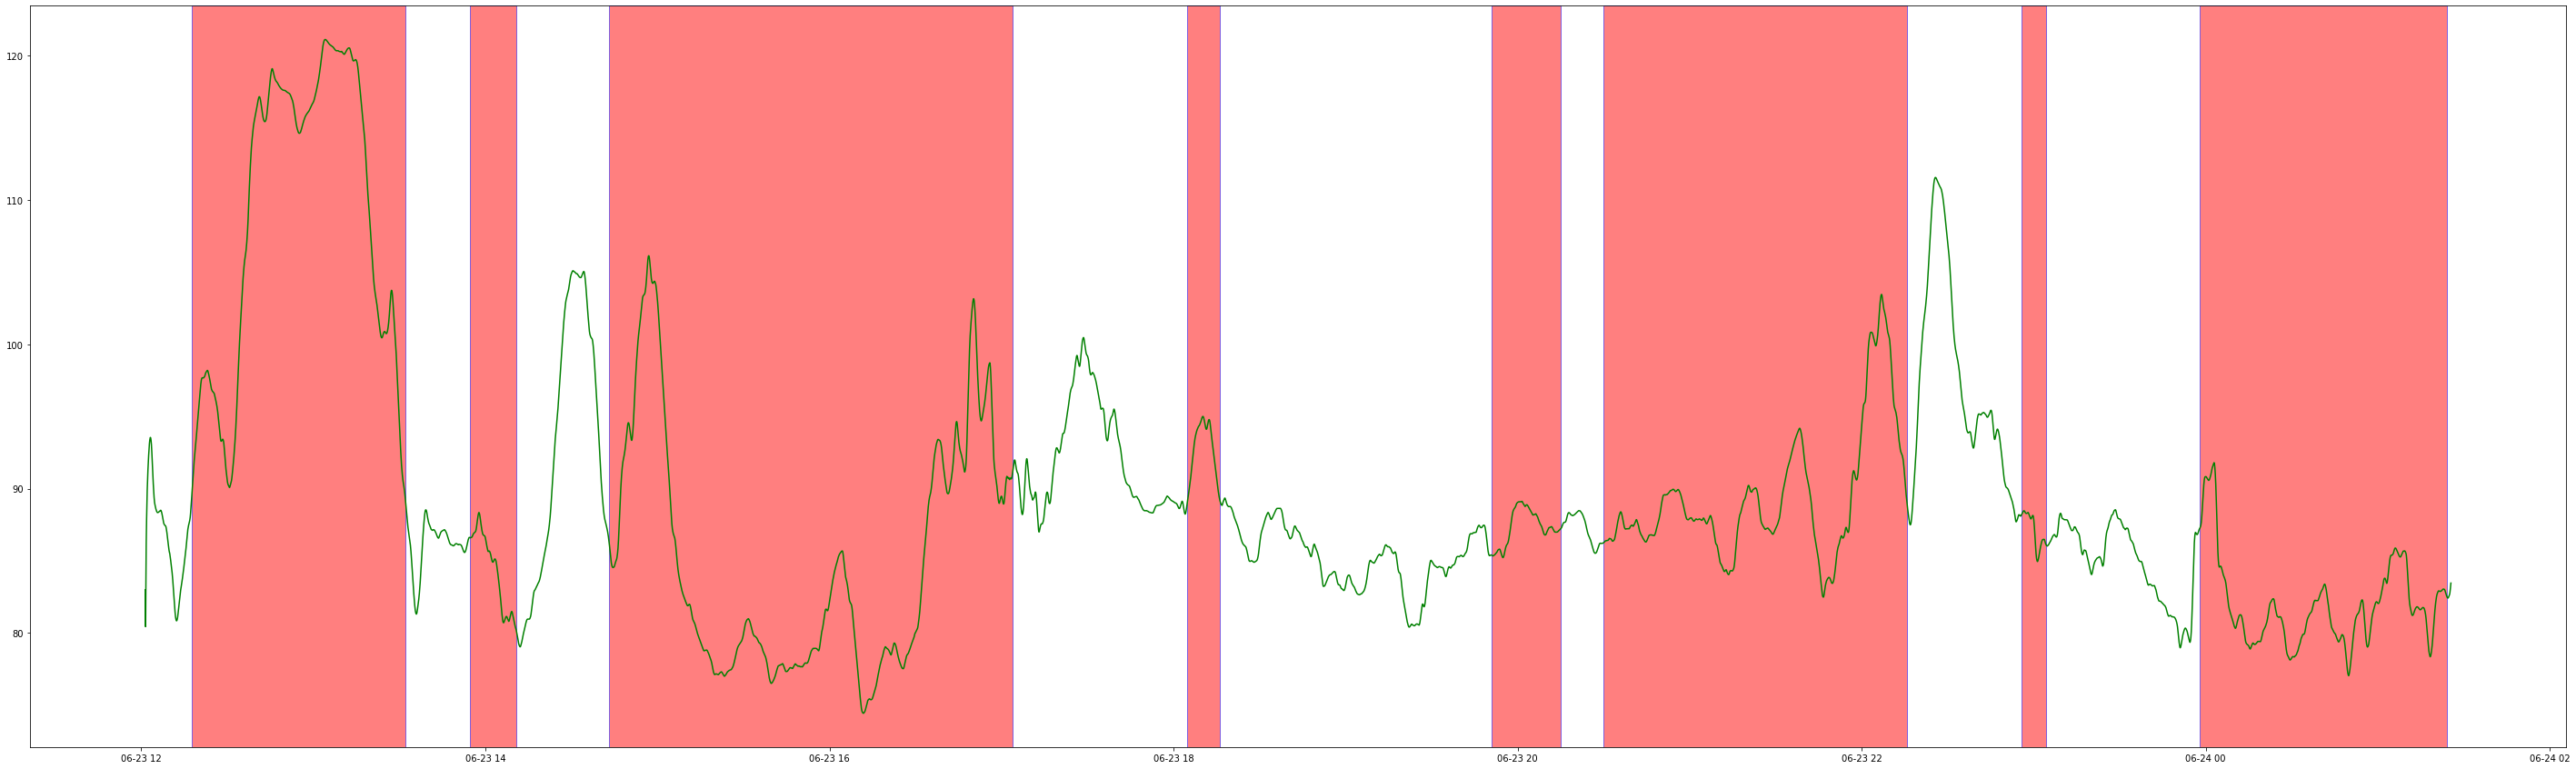

In [ ]:
fig = plt.figure(figsize=(70,10))
fig, ax1 = plt.subplots(figsize = (50,15))
# fig, ax1 = plt.subplot()
ax1.plot(hr_df['datetime'], hr_df['MAG_K300'], color = 'g')

for d in concatnated_frames_4.index:
    ax1.axvspan(concatnated_frames_4['Starting Timestamp'][d], concatnated_frames_4['Ending Timestamp'][d], facecolor = 'r', edgecolor='b', alpha = 0.5)
ax1.relim()
ax1.autoscale_view()

<Figure size 5040x720 with 0 Axes>

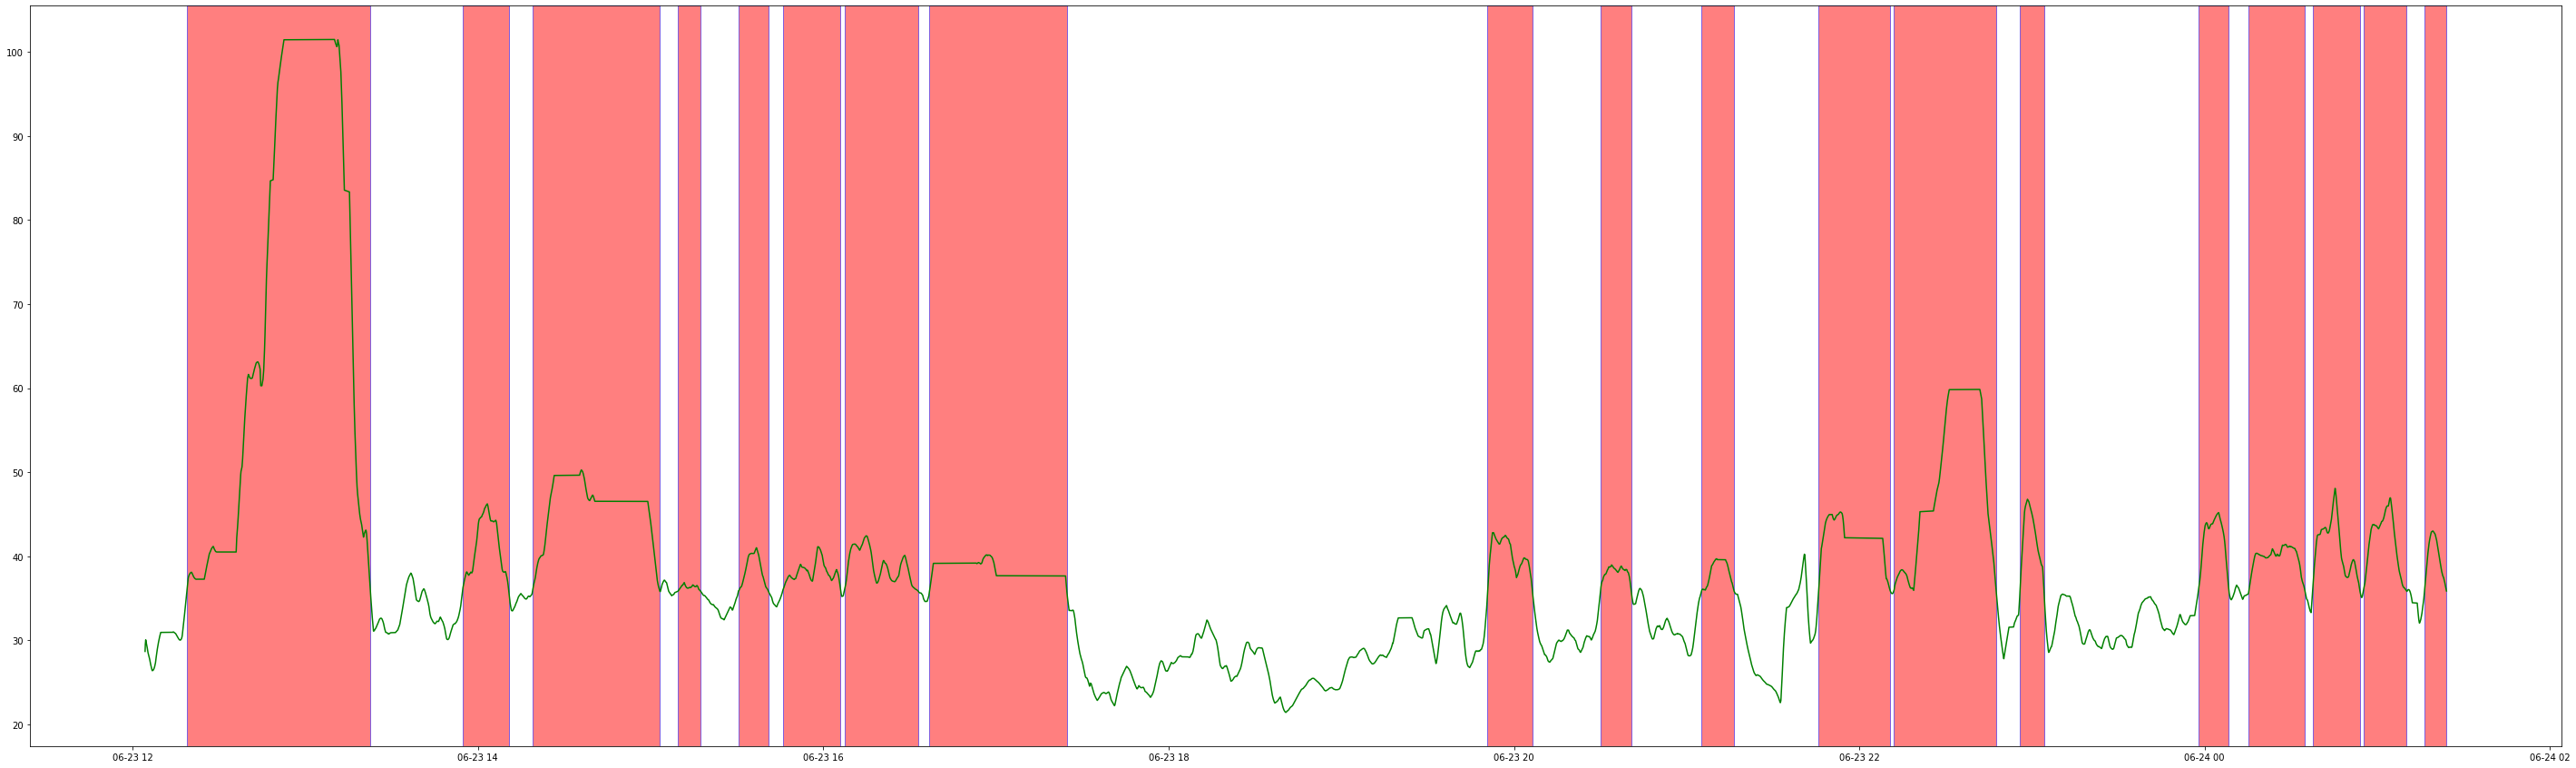

In [ ]:
fig = plt.figure(figsize=(70,10))
fig, ax1 = plt.subplots(figsize = (50,15))
# fig, ax1 = plt.subplot()
ax1.plot(hrv_features['datetime'], hrv_features['MAG_K300'], color = 'g')

for d in hrv_events_df.index:
    ax1.axvspan(hrv_events_df['Starting Timestamp'][d], hrv_events_df['Ending Timestamp'][d], facecolor = 'r', edgecolor='b', alpha = 0.5)
ax1.relim()
ax1.autoscale_view()

In [ ]:
concatnated_frames_4

,Starting Timestamp,Ending Timestamp
0,2021-06-23 12:17:29,2021-06-23 13:32:06
1,2021-06-23 13:54:36,2021-06-23 14:10:41
2,2021-06-23 14:43:15,2021-06-23 17:03:45
3,2021-06-23 18:04:53,2021-06-23 18:16:08
4,2021-06-23 19:50:50,2021-06-23 20:15:01
5,2021-06-23 20:30:04,2021-06-23 22:15:42
6,2021-06-23 22:55:50,2021-06-23 23:04:10
7,2021-06-23 23:57:49,2021-06-24 01:24:01
